In [9]:
import os

csv_files = []

for root, dirs, files in os.walk('.'):
    for file in files:
        if ('static' in file.lower() or 'increment' in file.lower() or 'increament' in file.lower()) and file.endswith('.csv'):
            csv_files.append(os.path.join(root, file))

print("CSV files with 'static', 'increment' or 'increament' in their names:", csv_files)

CSV files with 'static', 'increment' or 'increament' in their names: ['.\\result\\Claude3-haiku\\Claude3-haiku_Increament.csv', '.\\result\\Claude3-haiku\\Claude3-haiku_Static.csv', '.\\result\\Claude3-opus\\Claude3-opus_Increament.csv', '.\\result\\Claude3-opus\\Claude3-opus_Static.csv', '.\\result\\Claude3-sonnet\\Claude3-sonnet_Increament.csv', '.\\result\\Claude3-sonnet\\Claude3-sonnet_Static.csv', '.\\result\\FinLlama3\\FinLlama3_Increament.csv', '.\\result\\FinLlama3\\FinLlama3_Static.csv', '.\\result\\Gemini-1-pro\\Gemini-1-pro_Increament.csv', '.\\result\\Gemini-1-pro\\Gemini-1-pro_Static.csv', '.\\result\\Gemini-1.5-pro\\Gemini-1.5-pro_Increament.csv', '.\\result\\Gemini-1.5-pro\\Gemini-1.5-pro_Static.csv', '.\\result\\KB-ALbert\\KB-ALbert_Increament.csv', '.\\result\\KB-ALbert\\KB-ALbert_Static.csv', '.\\result\\KR-Finbert\\KR-Finbert_Increament.csv', '.\\result\\KR-Finbert\\KR-Finbert_Static.csv', '.\\result\\LLAMA-8B\\LLAMA-8B_Increament.csv', '.\\result\\LLAMA-8B\\LLAMA-8B

In [10]:
import pandas as pd
import numpy as np
import os

def calculate_metrics(df, metric_type):
    # 월별 수익률 계산
    if metric_type in df.columns:
        df['return'] = df[metric_type]
    else:
        raise ValueError(f"{metric_type} column is required.")

    # 월별 평균 수익률 계산
    monthly_avg_return = df['return'].mean()

    # 월별 수익률 편차 계산
    monthly_std = df['return'].std()

    # 월간 Sharpe Ratio 계산
    risk_free_rate = 0.0  # 무위험 이자율
    excess_return = df['return'] - risk_free_rate
    sharpe_ratio = excess_return.mean() / excess_return.std()

    initial_investment = 100000

    df['cumulative_return'] = (df['return'] / 100 + 1).cumprod() - 1
    df['cumulative_value'] = initial_investment * (1 + df['cumulative_return'])
    cumulative_return = df['cumulative_return']

    # MDD 계산
    peak = cumulative_return.max()
    valley = cumulative_return.min()
    mdd = (valley - peak) / peak

    # 최종 수익률 계산
    final_return = (cumulative_return.iloc[-1]) * 100

    return {
        'Monthly Average Return': f"{monthly_avg_return:.4f}%",
        'Monthly Standard Deviation': f"{monthly_std:.4f}%",
        'Monthly Sharpe Ratio': f"{sharpe_ratio:.4f}",
        'MDD': f"{mdd:.2f}%",
        'Final Return': f"{final_return:.2f}%"
    }

# 결과를 저장할 빈 리스트 생성
result_list = []

# 각 CSV 파일에 대해 함수 적용
for file in csv_files:
    try:
        df = pd.read_csv(file)

        # 파일명에서 모델명과 전략 유형 추출
        filename = os.path.basename(file)
        model_name, strategy_type = filename.split('_', 1)[:2]

        # pct_long, pct_short, avg_pct 각각에 대해 계산
        for metric_type in ['pct_long', 'pct_short', 'avg_pct']:
            if metric_type in df.columns:
                metrics = calculate_metrics(df, metric_type)
                metrics['Model'] = model_name
                if metric_type == 'pct_long':
                    metrics['Strategy'] = 'Long'
                elif metric_type == 'pct_short':
                    metrics['Strategy'] = 'Short'
                else:
                    metrics['Strategy'] = 'Long&Short'
                metrics['Method'] = 'Static' if 'Static' in strategy_type else 'increament'
                result_list.append(metrics)

    except Exception as e:
        print(f"Error processing file: {file}")
        print(f"Error message: {str(e)}")

# 결과를 DataFrame으로 변환
result_df = pd.DataFrame(result_list)

# 결과를 CSV 파일로 저장
try:
    result_df.to_csv('metrics_results.csv', index=False)
    print("Results saved to 'metrics_results.csv'")
except Exception as e:
    print("Error saving results to CSV.")
    print(f"Error message: {str(e)}")

Results saved to 'metrics_results.csv'


In [11]:
import pandas as pd

# 결과 CSV 파일을 불러오기
metrics_df = pd.read_csv('metrics_results.csv')

# Sharpe Ratio를 숫자형으로 변환하고 정렬하기
metrics_df['Monthly Sharpe Ratio'] = metrics_df['Monthly Sharpe Ratio'].astype(float)
top_5_sharpe_ratios = metrics_df.nlargest(5, 'Monthly Sharpe Ratio')

# 결과 출력
print(top_5_sharpe_ratios)


   Monthly Average Return Monthly Standard Deviation  Monthly Sharpe Ratio  \
33                1.2328%                    5.7327%                0.2150   
63                0.9378%                    5.4940%                0.1707   
42                0.7806%                    4.6187%                0.1690   
45                0.7000%                    5.2129%                0.1343   
51                0.7190%                    5.5425%                0.1297   

       MDD Final Return                  Model Strategy      Method  
33  -0.98%       46.80%         Gemini-1.5-pro     Long      Static  
63  -1.07%       32.59%  LLAMA3-8B-CL-filtered     Long      Static  
42  -0.79%       26.58%             KR-Finbert     Long  increament  
45  -1.15%       22.43%             KR-Finbert     Long      Static  
51  -0.78%       22.61%               LLAMA-8B     Long      Static  


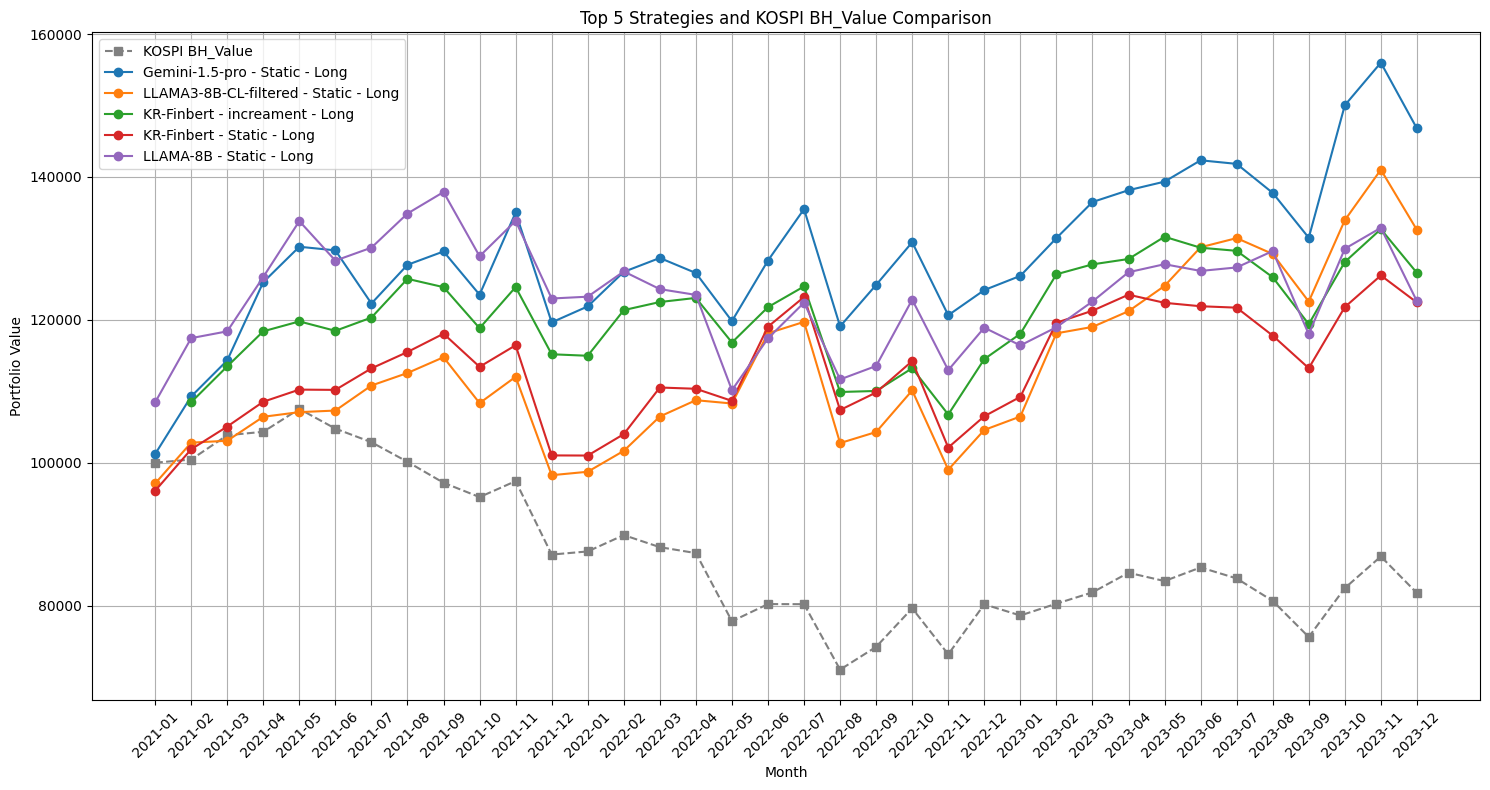

In [12]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# KOSPI 데이터 로드
kospi_df = pd.read_csv('./data/Kospi_2021_2023.csv')

# top_5_sharpe_ratios에서 모델, 메소드, 전략 정보를 추출
models = top_5_sharpe_ratios['Model']
methods = top_5_sharpe_ratios['Method']
strategies = top_5_sharpe_ratios['Strategy']

# 그래프를 그리기 위한 설정
plt.figure(figsize=(15, 8))
# KOSPI BH_Value 데이터 그리기
plt.plot(kospi_df['month'], kospi_df['BH_Value'], label='KOSPI BH_Value', marker='s', linestyle='--', color='grey')

# 첫 5행에 대한 정보를 이용해 파일을 찾고, 데이터를 로드 후 그래프로 표시
for model, method, strategy in zip(models, methods, strategies):
    filename = f"{model}_{method}.csv"
    found = False
    
    # 파일 시스템을 탐색하여 해당 파일 찾기
    for root, dirs, files in os.walk('.'):
        for file in files:
            if file.lower() == filename.lower():  # 파일명과 대소문자 구분 없이 비교
                filepath = os.path.join(root, file)
                df = pd.read_csv(filepath)
                if strategy in df.columns:
                    plt.plot(df['month'], df[strategy], label=f"{model} - {method} - {strategy}", marker='o')
                    found = True
                break
        if found:
            break


# 그래프 제목, 축 이름, 범례 설정
plt.title("Top 5 Strategies and KOSPI BH_Value Comparison")
plt.xlabel("Month")
plt.ylabel("Portfolio Value")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f'SR_Top5_evaluate.png')